# Python image processing workshop: codelab 02

## Part 1: Load data

In [3]:
from skimage.io import imread

filepath = r'..\example_images\example_cells.tif'
img = imread(filepath)

Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (930, 780)
Loaded values are of type: uint8


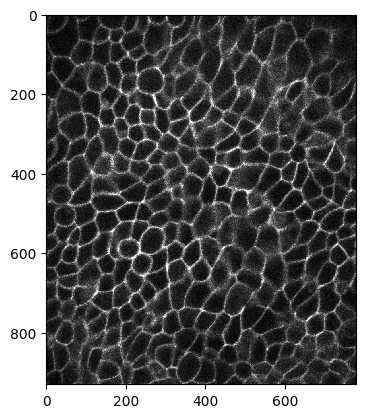

In [5]:
print("Loaded array is of type:", type(img))
print("Loaded array has shape:", img.shape)
print("Loaded values are of type:", img.dtype)
import matplotlib.pyplot as plt
plt.imshow(img, interpolation='none', cmap='gray')

## Part 2: Preprocessing

### Sec01: Smoothing

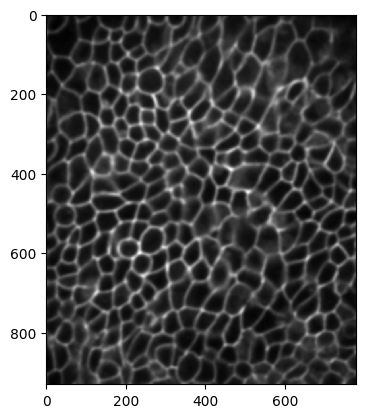

In [6]:
# Import the image processing module scipy.ndimage as ndi
import scipy.ndimage as ndi

# Define the sigma value for the Gaussian filter
sigma = 3
# Apply a Gaussian filter to the image
img_smooth = ndi.gaussian_filter(img, sigma)

# Show the original and the smoothed image
plt.figure()
plt.imshow(img_smooth, interpolation='none', cmap='gray')

### Sec02: Thresholding

In [7]:
# Define the threshold level
thresh = 70
# Apply thresholding
mem = img_smooth > thresh
# Check the data type of mem
print(mem.dtype)

bool


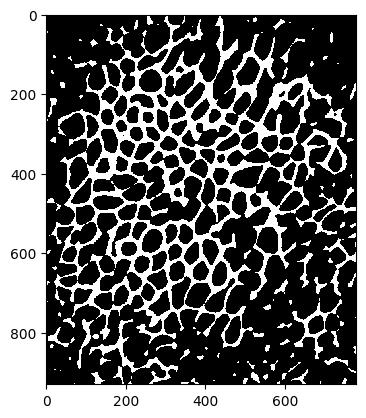

In [8]:
plt.imshow(mem, interpolation='none', cmap='gray')

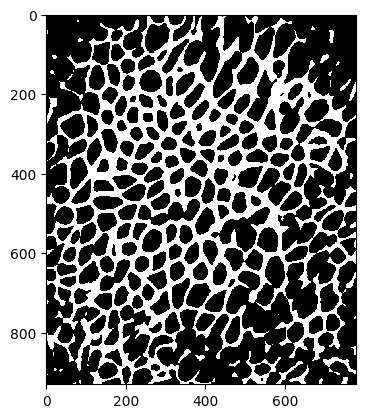

In [9]:
# Try automatic thresholding
from skimage.filters.thresholding import threshold_otsu

thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
plt.figure()
plt.imshow(mem, interpolation='none', cmap='gray')


### Sec03: Background substraction

Excercise:
Apply the mean filtering to get a background, then subtract the smoothed image with the background to get a background subtracted image.
Check the documentation here: https://scikit-image.org/docs/stable/auto_examples/filters/plot_rank_mean.html to apply a mean filtering to the image, to obtain a background image

Text(0.5, 1.0, 'Background subtracted')

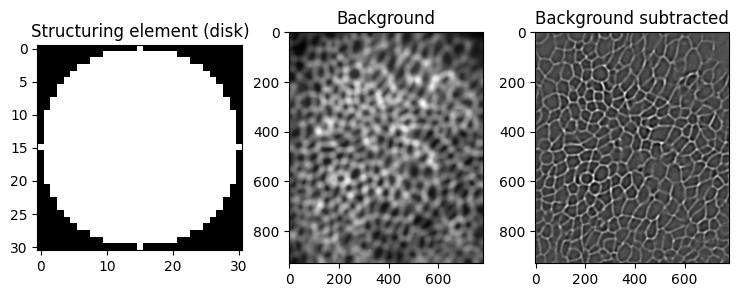

In [53]:
# Step 1: Create a structuring element (or footprint) and show it
from skimage.morphology import disk

footprint = disk(15)

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(footprint, interpolation='none', cmap='gray')
plt.title('Structuring element (disk)')
# Step 2: Apply the mean filter
from skimage.filters import rank 

background = rank.mean(img_smooth, footprint=footprint)
plt.subplot(132)
plt.imshow(background, interpolation='none', cmap='gray')
plt.title('Background')

# Step 3: Subtract the background
backgrund_subtracted = img_smooth.astype('float') - background.astype('float')
plt.subplot(133)
plt.imshow(backgrund_subtracted, interpolation='none', cmap='gray')
plt.title('Background subtracted')

## Part 3: Segmentation

### Sec01: Thresholding

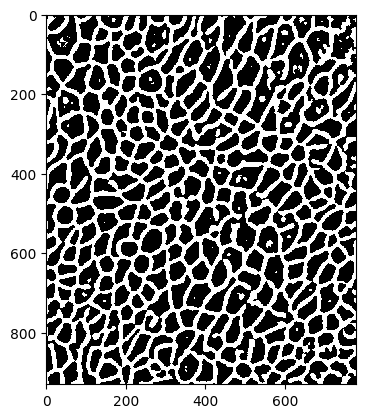

In [18]:
mem = backgrund_subtracted > 0
plt.figure()
plt.imshow(mem, interpolation='none', cmap='gray')

### Sec02: Improving masks with binary morphology

#### A. fill holes

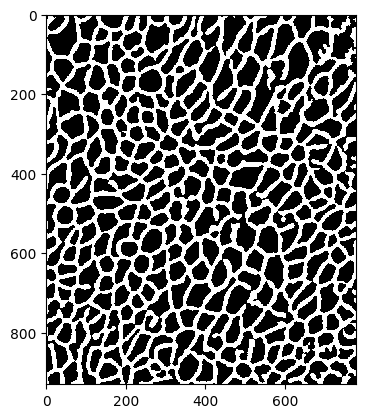

In [19]:
mem_holefilled = ~ndi.binary_fill_holes(~mem)
plt.imshow(mem_holefilled, interpolation='none', cmap='gray')

#### B. Closing (= Dilation + Erosion)

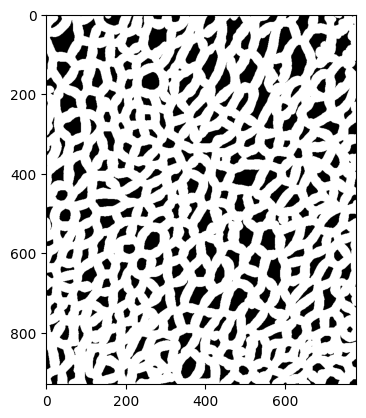

In [20]:
r = 7
SE = disk(r)

mem_dilated = ndi.binary_dilation(mem_holefilled, structure=SE)

plt.imshow(mem_dilated, cmap = 'gray');

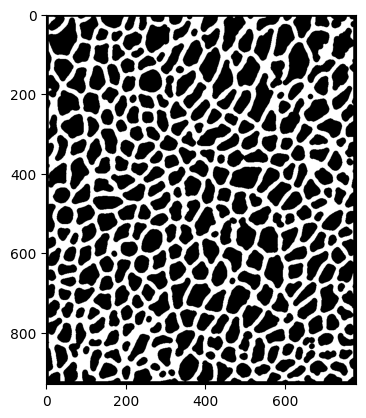

In [21]:
mem_eroded = ndi.binary_erosion(mem_dilated, structure=SE)

plt.imshow(mem_eroded, cmap = 'gray')

`ndi.binary_closing` can do this too!

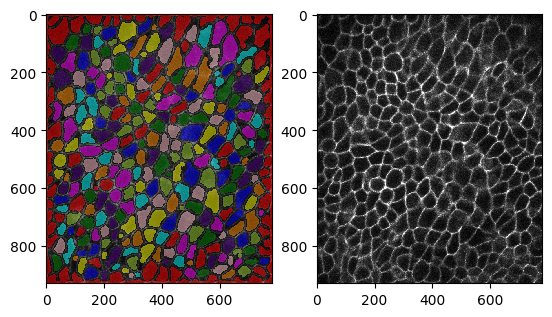

In [32]:
cell_labels = ndi.label(~mem_eroded)[0]
# Show the label on top of the original image
from skimage.color import label2rgb
image_label_overlay = label2rgb(cell_labels, image=img, bg_label=0, alpha=0.5)
plt.figure()
plt.subplot(121)
plt.imshow(image_label_overlay, interpolation='none')
plt.subplot(122)
plt.imshow(img, interpolation='none', cmap='gray')

### Sec03: Seeding for Watershed Transform

We can label the image as it is, but watershed can produce beter results

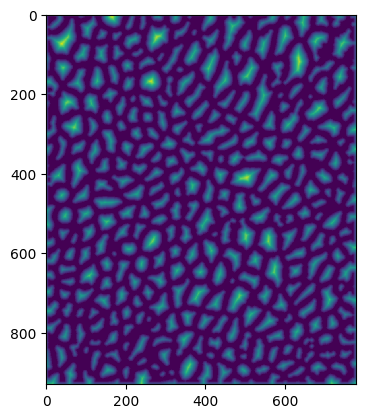

In [33]:
# (i) Run a distance transform on the membrane mask
# Use the function 'ndi.distance_transform_edt'
dist_trans = ndi.distance_transform_edt(~mem_eroded)
plt.imshow(dist_trans, interpolation='none', cmap='viridis')

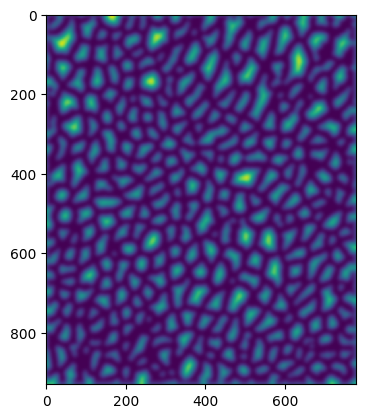

In [34]:
# (ii) Smoothen the distance transform
dist_trans_smooth = ndi.gaussian_filter(dist_trans, sigma=5)
plt.imshow(dist_trans_smooth, interpolation='none', cmap='viridis')

In [36]:
# (iii) Get the local maxima (the 'peaks') from the distance transform

# Use the function 'peak_local_max' from the module 'skimage.feature'. This function will return the
# indices/ coordinates of the pixels where the local maxima are. 
from skimage.feature import peak_local_max
import numpy as np

seeds = peak_local_max(dist_trans_smooth, min_distance=5)

# (iv) However, we instead need a boolean mask of the same shape as the original image, where all 
# the local maximum pixels are labeled as `1` and everything else as `0`.

# Let's do it step by step. First try have a look at what is in seeds. Can you get these values?
# Number of seeds
print(f'There are {np.shape(seeds)[0]} seeds')
# The X coordinate of the first seed
print(seeds[0][0])
# The Y coordinate of the 13th seed
print(seeds[13][1])

There are 312 seeds
73
685


In [37]:
# Now, we will start by creating a boolean matrix/ image same size as the original image, but with
# all pixel values as 0/ false
seeds_mask = np.zeros_like(dist_trans_smooth, dtype = bool)

# For loop through all entries in seeds
for seed_id in range(np.shape(seeds)[0]):
    seeds_mask[seeds[seed_id][0],seeds[seed_id][1]] = 1

# P.S. for advanced Python coder - this also works without a for loop:
# seeds_mask[tuple(seeds.T)] = True

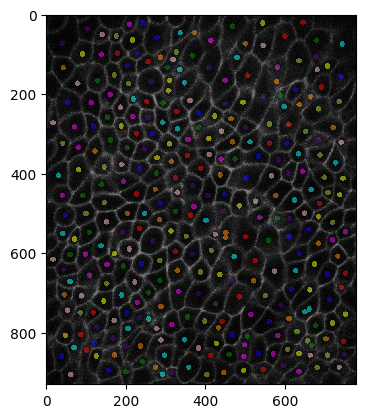

In [42]:
# (v) Visualize the output 

# Dilate the seeds for visulization
seeds_dil = ndi.binary_dilation(seeds_mask, structure=disk(7))
# Label the seeds
seeds_labeled = ndi.label(seeds_dil)[0]

image_seeds_overlay = label2rgb(seeds_labeled, image=img, bg_label=0, alpha=0.5)
plt.figure()
plt.imshow(image_seeds_overlay, interpolation='none')

### Sec04: Expansion by Watershed

In [40]:
# (i) Perform watershed

# Use the function 'watershed' from the module 'skimage.segmentation'.
# Use the labeled cell seeds and the smoothed membrane image as input.
from skimage.segmentation import watershed

ws = watershed(img_smooth, seeds_labeled)

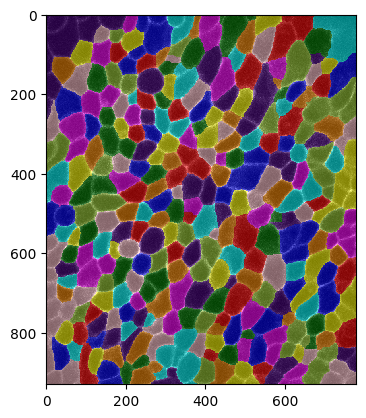

In [46]:
# (ii) Visulize

plt.figure()
image_label_overlay = label2rgb(ws, image=img, bg_label=0, alpha=0.5)
plt.imshow(image_label_overlay, interpolation='none')


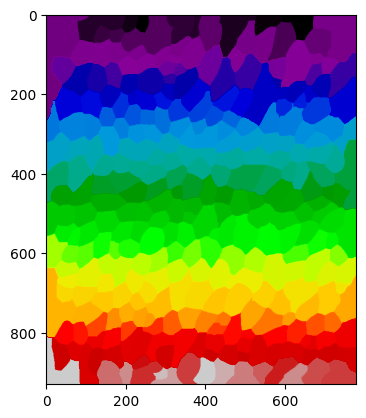

In [54]:
#  Show the original image and the labels on Napari
import napari
viewer = napari.Viewer()
viewer.add_image(img, name='Original image', colormap='gray')
label_layer = viewer.add_labels(ws, name='Segmented cells')


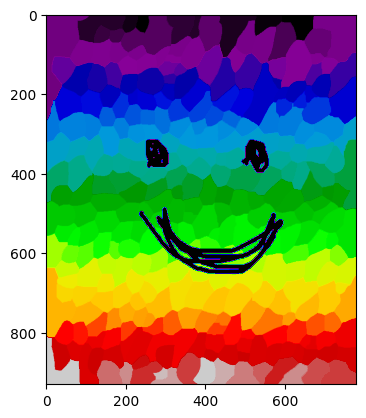

In [55]:
# Extract the labeled image
labeled_image = label_layer.data
# Show the labeled image
plt.imshow(labeled_image, cmap='nipy_spectral')

You will find that most of the "mis-segmented" cells are at the boarder of the image - We will think about how to remove them in the last section

### Sec05: Save the result

In [48]:
# Save the segmented image
from skimage.io import imsave

imsave('segmented_cells.tif', ws)

C:\Users\OWNER\AppData\Local\Temp\ipykernel_29164\3782385875.py:4: UserWarning: segmented_cells.tif is a low contrast image
  imsave('segmented_cells.tif', ws)
